In [1]:
import sys
import os
import rospkg
FE_PATH = rospkg.RosPack().get_path('frontier_exploration')
sys.path.append(os.path.join(FE_PATH, 'src/'))
import torch
from tqdm.notebook import tqdm
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import look_at_view_transform

from tools import render_pc_image
from tools import hidden_pts_removal
from tools import get_cam_frustum_pts
from tools import load_intrinsics

INFO - 2021-03-23 15:51:44,203 - topics - topicmanager initialized


### Define model to optimize trajectory

In [2]:
class Model(nn.Module):
    def __init__(self,
                 points,
                 traj_wps,
                 min_dist=1.0, max_dist=10.0,
                 dist_rewards_mean=3.0, dist_rewards_sigma=2.0):
        super().__init__()
        self.points = points
        self.rewards = None
        self.observations = None
        self.device = points.device
        self.lo_sum = 0.0  # log odds sum for the entire point cloud for the whole trajectory

        # Create an optimizable parameter for the x, y, z position of the camera.
        R = torch.eye(3, device=self.device).unsqueeze(0)
        for i in range(len(traj_wps)-1):
            R = torch.cat([R, torch.eye(3, device=self.device).unsqueeze(0)])  # (N, 3, 3)
        T = torch.from_numpy(np.array(traj_wps, dtype=np.float32)).to(self.device)  # (N, 3)

        # TODO: include yaw rotation as an optimizable model parameter
        self.T = nn.Parameter(T)
        self.R = nn.Parameter(R)

        self.K, self.width, self.height = load_intrinsics(device=self.device)
        self.eps = 1e-6
        self.pc_clip_limits = [min_dist, max_dist]  # [m]
        self.dist_rewards = {'mean': dist_rewards_mean, 'dist_rewards_sigma': dist_rewards_sigma}

    @staticmethod
    def get_dist_mask(points, min_dist=1.0, max_dist=5.0):
        # clip points between MIN_DIST and MAX_DIST meters distance from the camera
        dist_mask = (points[2] > min_dist) & (points[2] < max_dist)
        return dist_mask

    @staticmethod
    def get_fov_mask(points, img_height, img_width, intrins):
        # find points that are observed by the camera (in its FOV)
        pts_homo = intrins[:3, :3] @ points
        pts_homo[:2] /= pts_homo[2:3]
        fov_mask = (pts_homo[2] > 0) & (pts_homo[0] > 1) & \
                   (pts_homo[0] < img_width - 1) & (pts_homo[1] > 1) & \
                   (pts_homo[1] < img_height - 1)
        return fov_mask

    def to_camera_frame(self, verts, R, T):
        R_inv = torch.transpose(torch.squeeze(R, 0), 0, 1)
        verts = torch.transpose(verts - torch.repeat_interleave(T, len(verts), dim=0).to(self.device), 0, 1)
        verts = torch.matmul(R_inv, verts)
        verts = torch.transpose(verts, 0, 1)
        return verts

    @staticmethod
    def gaussian(x, mu=3.0, sigma=100.0, normalize=False):
        # https://en.wikipedia.org/wiki/Normal_distribution
        g = torch.exp(-0.5 * ((x - mu) / sigma) ** 2)
        if normalize:
            g /= (sigma * torch.sqrt(torch.tensor(2 * np.pi)))
        return g

    def distance_visibility(self, verts, pose):
        # compute observations based on distance of the surrounding points
        dists = torch.linalg.norm(pose - verts, dim=1)
        rewards = self.gaussian(dists, mu=self.dist_rewards['mean'], sigma=self.dist_rewards['dist_rewards_sigma'])
        return rewards

    def forward(self):
        """
        Trajectory evaluation based on visibility estimation from its waypoints.
        traj_score = log_odds_sum([visibility_estimation(wp) for wp in traj_waypoints])
        """
        N_wps = self.T.size()[0]
        lo_sum = 0.0
        for i in range(N_wps):
            # transform points to camera frame
            verts = self.to_camera_frame(self.points, self.R[i].unsqueeze(0), self.T[i].unsqueeze(0))

            # get masks of points that are inside of the camera FOV
            dist_mask = self.get_dist_mask(verts.T, self.pc_clip_limits[0], self.pc_clip_limits[1])
            fov_mask = self.get_fov_mask(verts.T, self.height, self.width, self.K.squeeze(0))

            mask = torch.logical_and(dist_mask, fov_mask)

            # remove points that are outside of camera FOV
            verts = verts[mask, :]

            p = self.distance_visibility(self.points, self.T[i].unsqueeze(0)) * mask  # local observations reward (visibility)
        
            # apply log odds conversion for global voxel map observations update
            p = torch.clip(p, 0.5, 1 - self.eps)
            lo = torch.log(p / (1 - p))
            lo_sum = lo_sum + lo
        
        self.rewards = 1 / (1 + torch.exp(-lo_sum))  # total trajectory observations
        loss = self.criterion(self.rewards)
        return verts, loss

    def criterion(self, observations, use_wps_loss=False, wps_dist_scale=1e-7):
        # transform observations to loss function: loss = 1 / sum(prob(observed))
        loss = 1. / (torch.sum(observations) - 0.5*self.points.size()[0] + self.eps)
        # add penalties for close waypoints
        if use_wps_loss:
            for i in range(self.T.size()[0]-1):
                p1 = self.T[i]
                p2 = self.T[i+1]
                loss_wp = torch.linalg.norm(p1 - p2) * wps_dist_scale
                loss = loss + loss_wp
        return loss


### Load point cloud

In [3]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
# Set paths
index = 1612893730.3432848
points_filename = os.path.join(FE_PATH, f"data/points/point_cloud_{index}.npz")
pts_np = np.load(points_filename)['pts'].transpose()

# make sure the point cloud is of (N x 3) shape:
if pts_np.shape[1] > pts_np.shape[0]:
    pts_np = pts_np.transpose()
points = torch.tensor(pts_np, dtype=torch.float32).to(device)

poses_filename = os.path.join(FE_PATH, f"data/paths/path_poses_{index}.npz")
traj_wps = np.load(poses_filename)['poses'].tolist()

### Define the model

In [4]:
# Initialize a model
model = Model(points=points,
              traj_wps=traj_wps).to(device)
# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

### Optimization loop

Loss: 0.00019711472850758582
Trajectory visibility score: 67280.1875


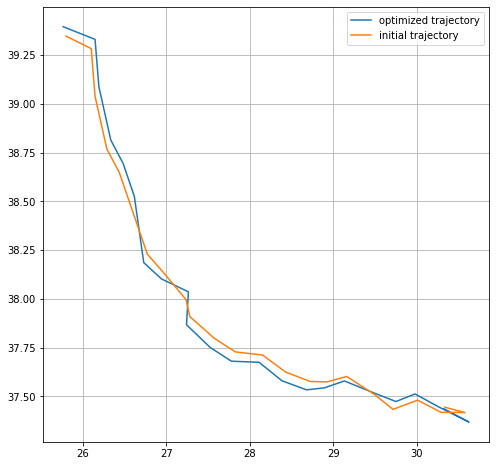

Loss: 0.00018672038277145475
Trajectory visibility score: 67562.6015625


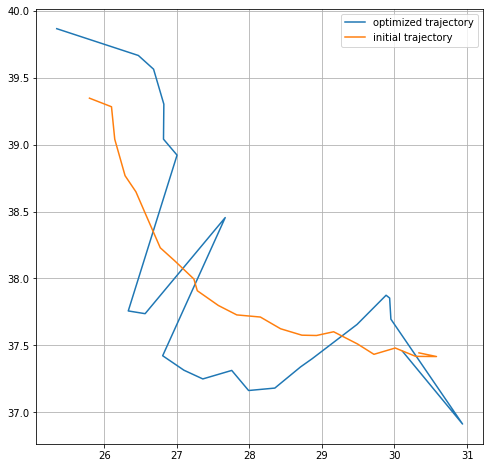

Loss: 0.00017502071568742394
Trajectory visibility score: 67920.609375


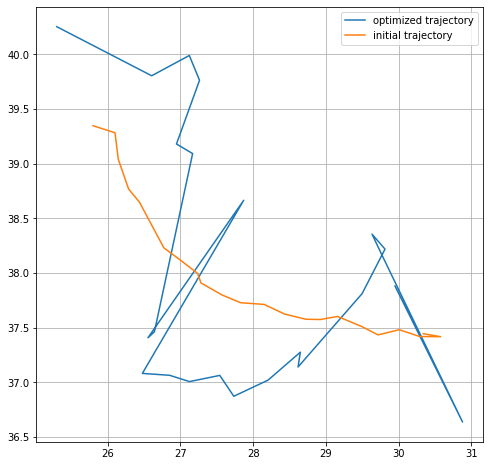

Loss: 0.00015506900672335178
Trajectory visibility score: 68655.7421875


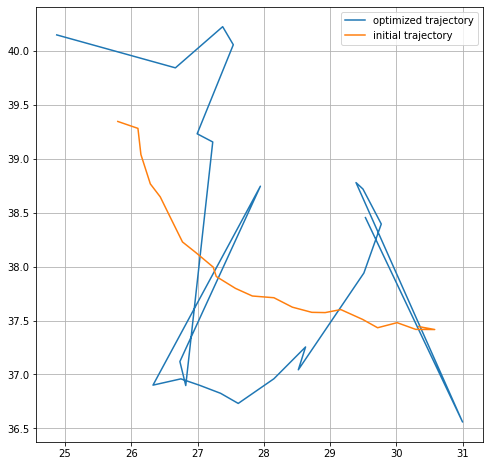

Loss: 0.00013990049774292856
Trajectory visibility score: 69354.9375


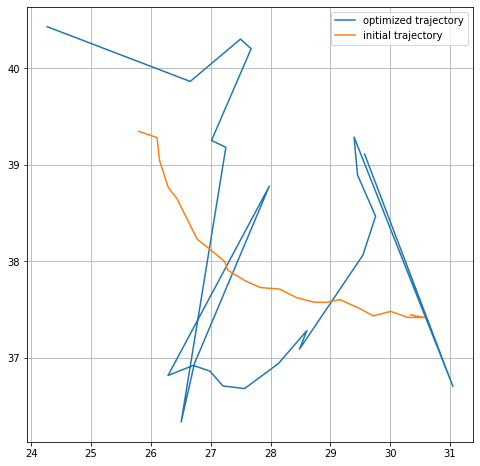

Loss: 0.00013505613605957478
Trajectory visibility score: 69611.328125


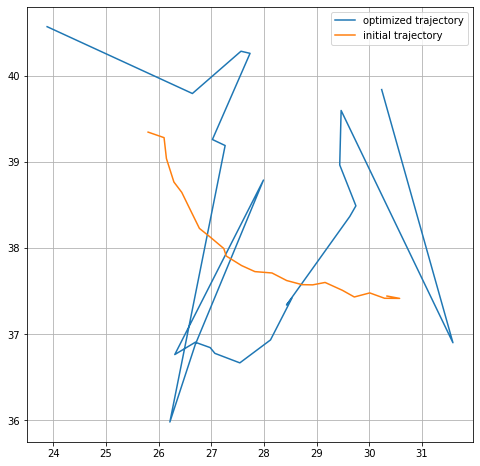

Loss: 0.00013076316099613905
Trajectory visibility score: 69854.4140625


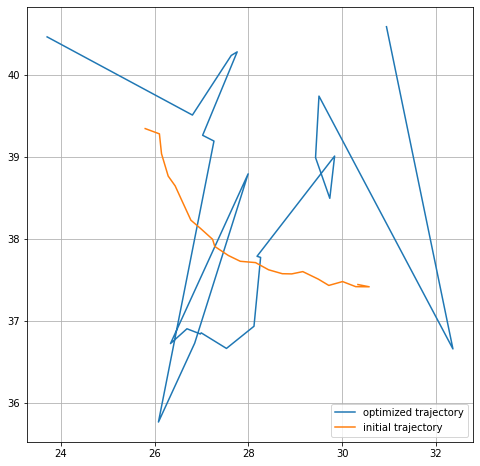

Loss: 0.000126293147332035
Trajectory visibility score: 70125.0859375


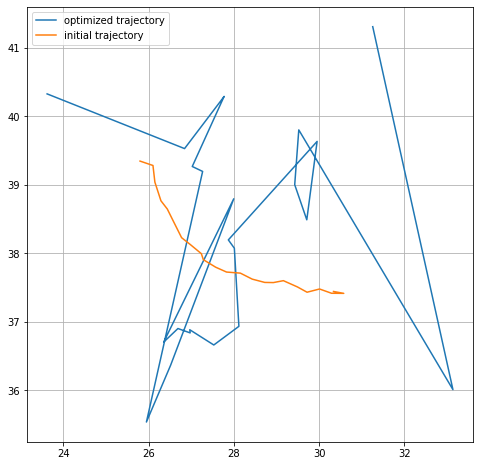

Loss: 0.00012482823512982577
Trajectory visibility score: 70218.0078125


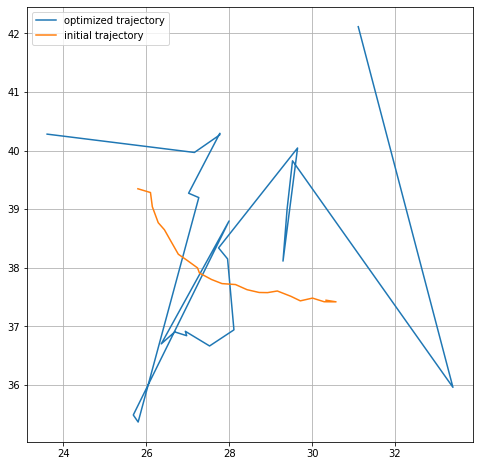

Loss: 0.00011771110439440235
Trajectory visibility score: 70702.375


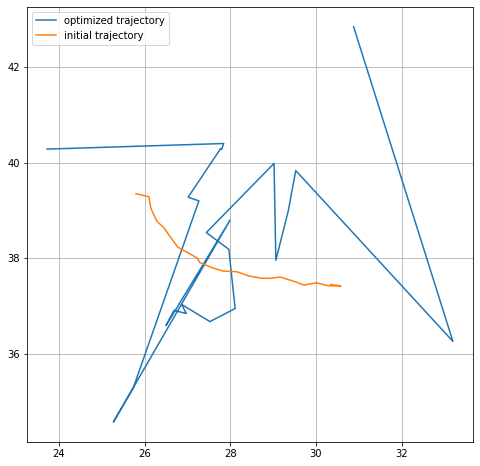

In [5]:
# Run optimization loop
traj_0 = np.asarray(traj_wps)

loop = tqdm(range(100))
for i in loop:
    optimizer.zero_grad()
    verts, loss = model()
    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(f"Loss: {loss.item()}")
        print(f"Trajectory visibility score: {torch.sum(model.rewards)}")
        
        traj = model.T.detach()

        plt.figure(figsize=(8, 8))
        plt.grid()
        plt.plot(traj[:, 0], traj[:, 1], label='optimized trajectory')
        plt.plot(traj_0[:, 0], traj_0[:, 1], label='initial trajectory')
        plt.legend()
        plt.show();